<a href="https://colab.research.google.com/github/Priesemann-Group/covid19_inference/blob/master/scripts/example_bundeslaender.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


This file create the model with three changing points of the paper https://science.sciencemag.org/content/early/2020/05/14/science.abb9789. 

It implements an Hierarchical Bayesian Model for all German states (Bundeslaender).


## Installation
Run this if the module isn't installed yet, or you run it in Google Colab:

In [ ]:
!pip install git+https://github.com/Priesemann-Group/covid19_inference_forecast.git

## Importing modules

In [2]:
import datetime
import time as time_module
import sys
import os 

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats
import theano
import matplotlib
import pymc3 as pm
import theano.tensor as tt

try: 
    import covid19_inference as cov19
except ModuleNotFoundError:
    sys.path.append('..')
    import covid19_inference as cov19

## Creating the model

This cell downloads data and builds the pymc3 model for the Bayesian inference. More information can be found in the [documentation](https://covid19-inference.readthedocs.io/en/latest/doc/gettingstarted.html).

In [13]:
#Dates to obtain the data from
date_begin_data = datetime.datetime(2020,3,10)
date_end_data   = datetime.datetime(2020,4,19)

#Downloads 2-D array of new cases (for each state) from the Robert Koch Institute
rki = cov19.data_retrieval.RKI(True)
df_bundeslaender = rki.filter_all_bundesland(date_begin_data, date_end_data)
new_cases_obs = np.diff(np.array(df_bundeslaender),axis=0)[:,:]

#1D array of state population, ordered alphabetically
N_state = [10880000, 12844000, 3520000, 2485000, 671000, 1787000, 6176000, 
           7927000, 1612000, 17865000, 4053000, 996000, 4085000, 2245000, 2859000, 2171000]

#Number of days the simulation starts earlier than the data.
#Should be significantly larger than the expected delay in order to always fit the same number of data points.
diff_data_sim = 16

#Number of days in the future (after date_end_data) to forecast cases
num_days_forecast = 10

# Change point midpoint dates
prior_date_mild_dist_begin =  datetime.datetime(2020,3,11)
prior_date_strong_dist_begin =  datetime.datetime(2020,3,18)
prior_date_contact_ban_begin =  datetime.datetime(2020,3,25)

#Structures change points in a dict. Variables not passed will assume default values.
change_points = [dict(pr_mean_date_transient = prior_date_mild_dist_begin,
                      pr_sigma_date_transient = 1.5,
                      pr_median_lambda = 0.2,
                      pr_sigma_lambda = 0.5,
                     pr_sigma_transient_len=0.5),
                 dict(pr_mean_date_transient = prior_date_strong_dist_begin,
                      pr_sigma_date_transient = 1.5,
                      pr_median_lambda = 1/8,
                      pr_sigma_lambda = 0.5,
                     pr_sigma_transient_len=0.5),
                 dict(pr_mean_date_transient = prior_date_contact_ban_begin,
                      pr_sigma_date_transient = 1.5,
                      pr_median_lambda = 1/8/2,
                      pr_sigma_lambda = 0.5,
                     pr_sigma_transient_len=0.5)];

#Stores the model parameters in a dict
params_model = dict(new_cases_obs = new_cases_obs[:],
                    data_begin = date_begin_data,
                    fcast_len = num_days_forecast,
                    diff_data_sim = diff_data_sim,
                    N_population = N_state) 

#The true model is defined in a context manager.
#Check https://docs.pymc.io/notebooks/getting_started.html for details on it.
with cov19.Cov19Model(**params_model) as this_model:
    
    # Create the array of the time dependent infection rate lambda
    lambda_t_log = cov19.lambda_t_with_sigmoids(pr_median_lambda_0 = 0.4, pr_sigma_lambda_0 = 0.5,
                                                change_points_list = change_points)
    
    #Median of the prior for the delay in case reporting
    pr_median_delay = 10
    
    #Adds the recovery rate mu to the model as a random variable
    mu = pm.Lognormal(name="mu", mu=np.log(1/8), sigma=0.2)
    
    # This builds a decorrelated prior for I_begin for faster inference. 
    # It is not necessary to use it, one can simply remove it and use the default argument 
    # for pr_I_begin in cov19.SIR
    prior_I = cov19.make_prior_I(lambda_t_log, mu, pr_median_delay = pr_median_delay)
    
    # Use lambda_t_log and mu to run the SIR model
    new_I_t = cov19.SIR(lambda_t_log, mu, pr_I_begin = prior_I)
    
    # Delay the cases by a lognormal reporting delay    
    new_cases_inferred_raw = cov19.delay_cases(new_I_t, pr_median_delay=pr_median_delay, 
                                               pr_median_scale_delay=0.3)
    
    # Modulate the inferred cases by a abs(sin(x)) function, to account for weekend effects
    new_cases_inferred = cov19.week_modulation(new_cases_inferred_raw)
    
    # Define the likelihood, uses the new_cases_obs set as model parameter
    cov19.student_t_likelihood(new_cases_inferred)

## MCMC sampling

After the model is built, it is sampled using an MCMC sampler. The number of parallel runs can be set with the argument `cores=`. In particular, due to a bug in Theano, Windows users should set `cores=1`. The sampling can take a long time.

In [15]:
trace = pm.sample(model=model, tune=1000, draws=1000, init='advi+adapt_diag')

Auto-assigning NUTS sampler...
INFO     [pymc3] Auto-assigning NUTS sampler...
Initializing NUTS using advi+adapt_diag...
INFO     [pymc3] Initializing NUTS using advi+adapt_diag...
Average Loss = 3,242.2:  27%|██▋       | 54399/200000 [02:36<06:59, 346.68it/s]
Convergence achieved at 54400
INFO     [pymc3.variational.inference] Convergence achieved at 54400
Interrupted at 54,399 [27%]: Average Loss = 3,616.2
INFO     [pymc3.variational.inference] Interrupted at 54,399 [27%]: Average Loss = 3,616.2
Multiprocess sampling (4 chains in 4 jobs)
INFO     [pymc3] Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma_obs, offset_modulation_rad, weekend_factor_log_L2_raw, weekend_factor_log_L1, sigma_weekend_factor_L2, delay_log_L2_raw, delay_log_L1, sigma_delay_L2, I_begin_ratio_log, mu, transient_len_3_log_L2_raw, transient_len_3_log_L1, sigma_transient_len_3_L2, transient_len_2_log_L2_raw, transient_len_2_log_L1, sigma_transient_len_2_L2, transient_len_1_log_L2_raw, transient_len_1_log_L1

# Plotting

We below we plot the posterior distributions of selected parameters, and the resulting number of cases for each state.

### Variables
The model uses a large number of parameters, and internally creates new versions (e.g. var_log_) for handling. All defined parameters can be found in `trace.varnames`, and all traces are found in `trace[varname]`.

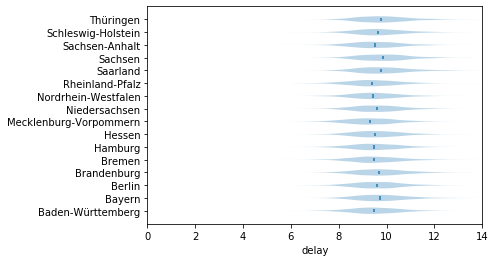

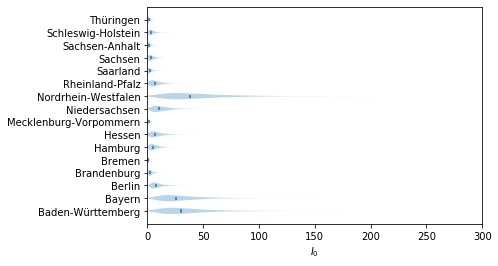

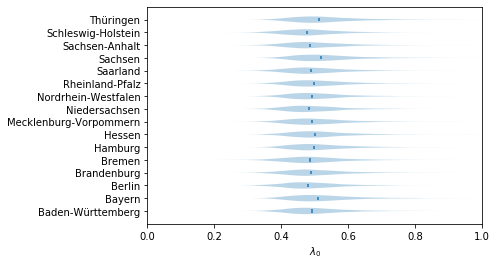

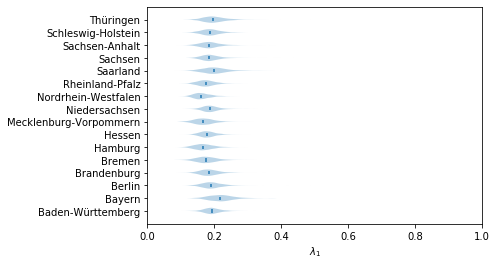

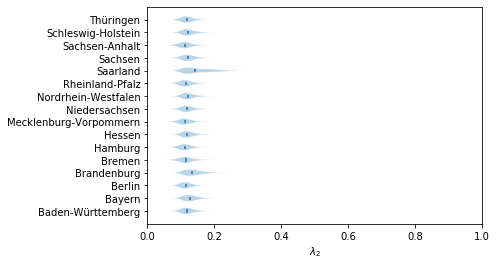

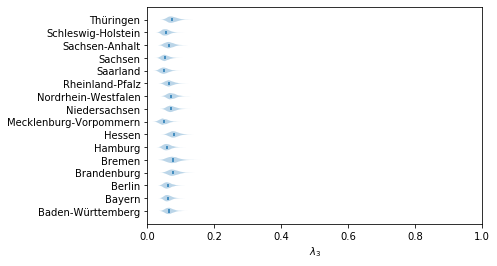

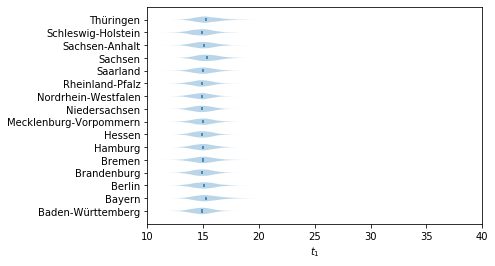

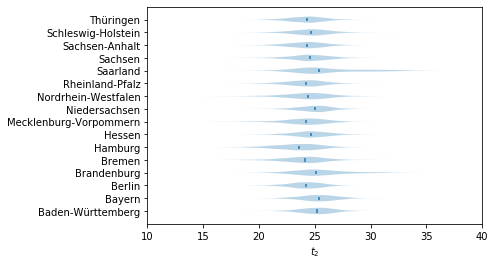

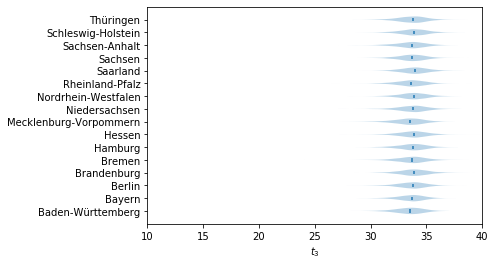

In [125]:
#Defines plotted variables, their names and plotting range
var_names = {
    'delay_L2' : {'name':'delay', 'xlim':[0,14]},
    'I_begin' : {'name':r'$I_0$', 'xlim':[0,300]},
    'lambda_0_L2' : {'name':r'$\lambda_0$', 'xlim':[0,1]},
    'lambda_1_L2' : {'name':r'$\lambda_1$', 'xlim':[0,1]},
    'lambda_2_L2' : {'name':r'$\lambda_2$', 'xlim':[0,1]},
    'lambda_3_L2' : {'name':r'$\lambda_3$', 'xlim':[0,1]},
    'transient_day_1_L2' : {'name':r'$t_1$', 'xlim':[10,40]},
    'transient_day_2_L2' : {'name':r'$t_2$', 'xlim':[10,40]},
    'transient_day_3_L2' : {'name':r'$t_3$', 'xlim':[10,40]},
}

#Plots violin plots
for var_name in var_names.keys():
    f, ax = plt.subplots()
    ax.violinplot(trace[var_name], showextrema=False, vert=False, showmedians=True)
    ax.set_yticks(np.arange(1,17))
    ax.set_yticklabels(df_bundeslaender.columns)
    ax.set_xlabel(var_names[var_name]['name'])
    ax.set_xlim(var_names[var_name]['xlim'])

### Number of cases

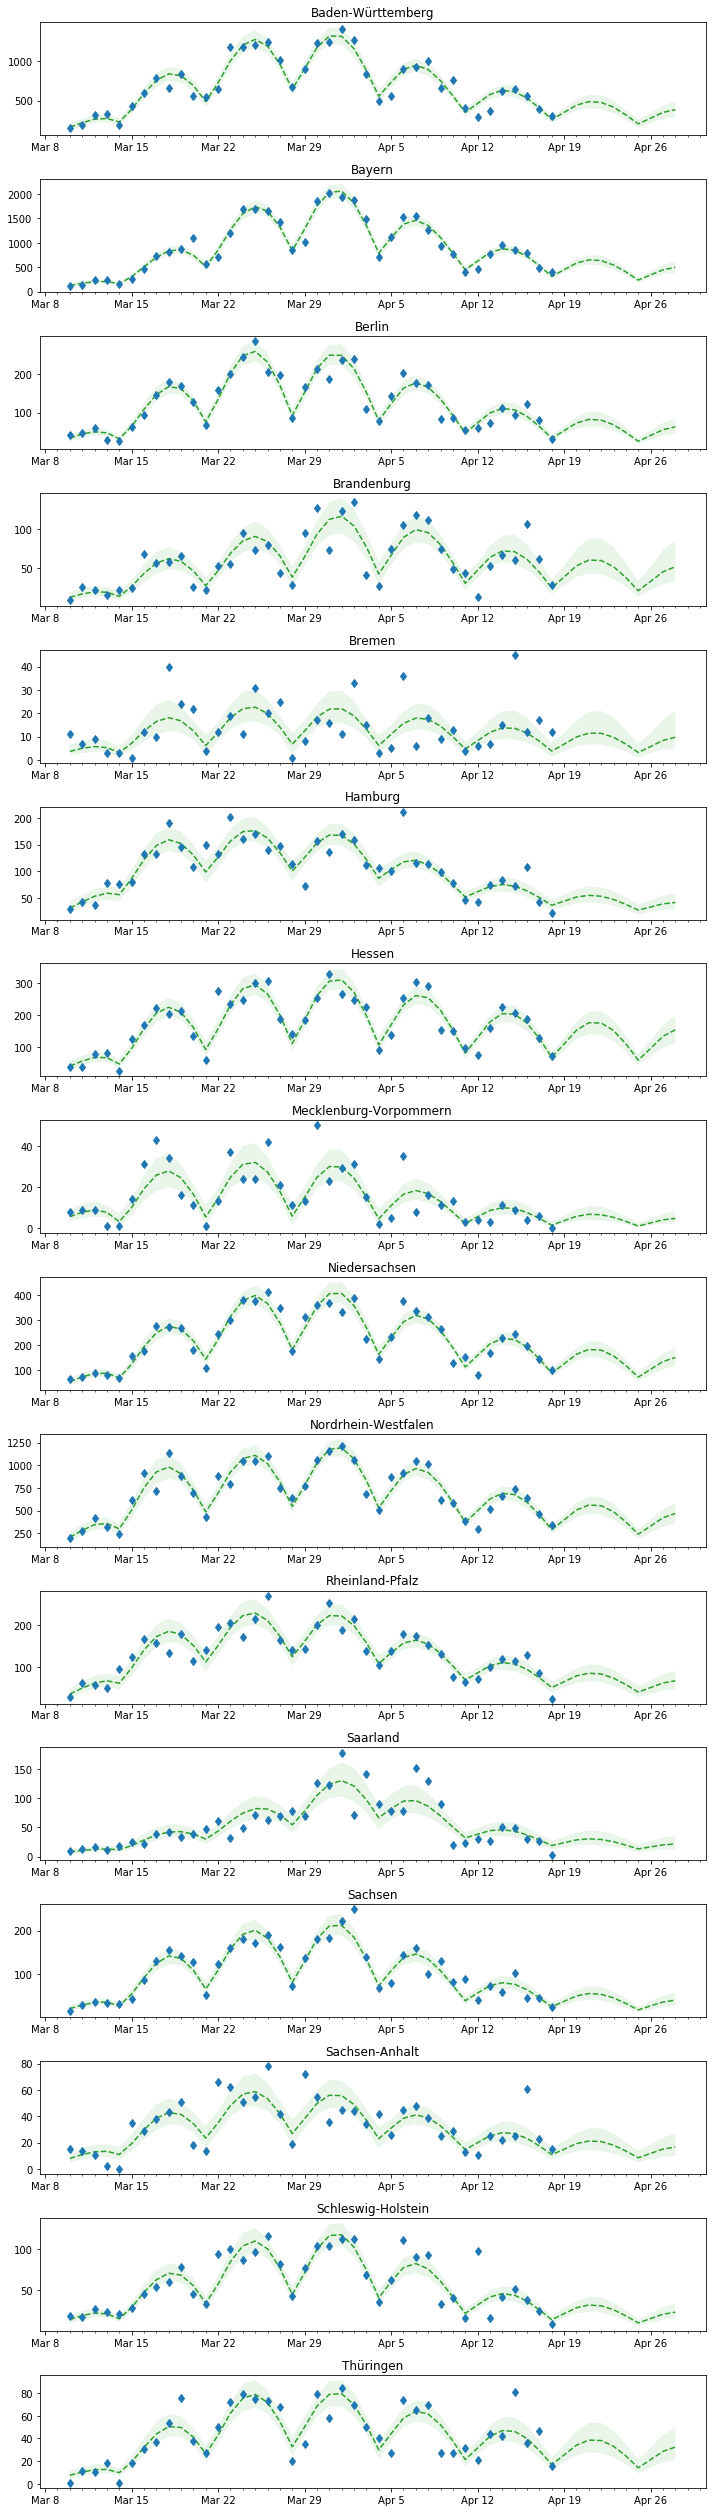

In [114]:
# First define the x range on which we want to plot. Should be within the simulation period.
bd = datetime.datetime(2020,3,10)
ed = datetime.datetime(2020,4,19) + datetime.timedelta(days=num_days_forecast-1)

# Next we have to get our trace corresponding to that date range. We do that by calling the helper function `cov19.plot._get_array_from_trace_via_date()`.
y_all_regions, x = cov19.plot._get_array_from_trace_via_date(model,trace,"new_cases",bd,ed)

# After retrieving the trace var for our specified time period, we plot the timeseries for each region. Additionaly we set the format of the date (x-)axis.
# We have 16 regions in this example -> we create 16 subplots 
fig, axes = plt.subplots(16,1,figsize=(10,35))

for i in range(16):
    y = y_all_regions[:,:,i]
    cov19.plot._timeseries(x,y, axes[i],what="fcast")
    axes[i].set_title(df_bundeslaender.columns[i])
    cov19.plot._format_date_xticks(axes[i])

#Furthermore, we can plot our observable i.e. our new_cases_obs.
x_dat = pd.date_range(model.data_begin,model.data_end)
for i in range(16):
    y = new_cases_obs[:,i]
    cov19.plot._timeseries(x_dat,y, axes[i],what="data",lw=0)
    
plt.tight_layout()

Dimension of lambda_0_log_L2_raw larger than one, skipping
Dimension of lambda_1_log_L2_raw larger than one, skipping
Dimension of lambda_2_log_L2_raw larger than one, skipping
Dimension of lambda_3_log_L2_raw larger than one, skipping
Dimension of transient_day_1_L2_raw larger than one, skipping
Dimension of transient_day_2_L2_raw larger than one, skipping
Dimension of transient_day_3_L2_raw larger than one, skipping
Dimension of transient_len_1_log_L2_raw larger than one, skipping
Dimension of transient_len_2_log_L2_raw larger than one, skipping
Dimension of transient_len_3_log_L2_raw larger than one, skipping
Dimension of I_begin_ratio_log larger than one, skipping
Dimension of delay_log_L2_raw larger than one, skipping
Dimension of weekend_factor_log_L2_raw larger than one, skipping
Dimension of sigma_obs larger than one, skipping


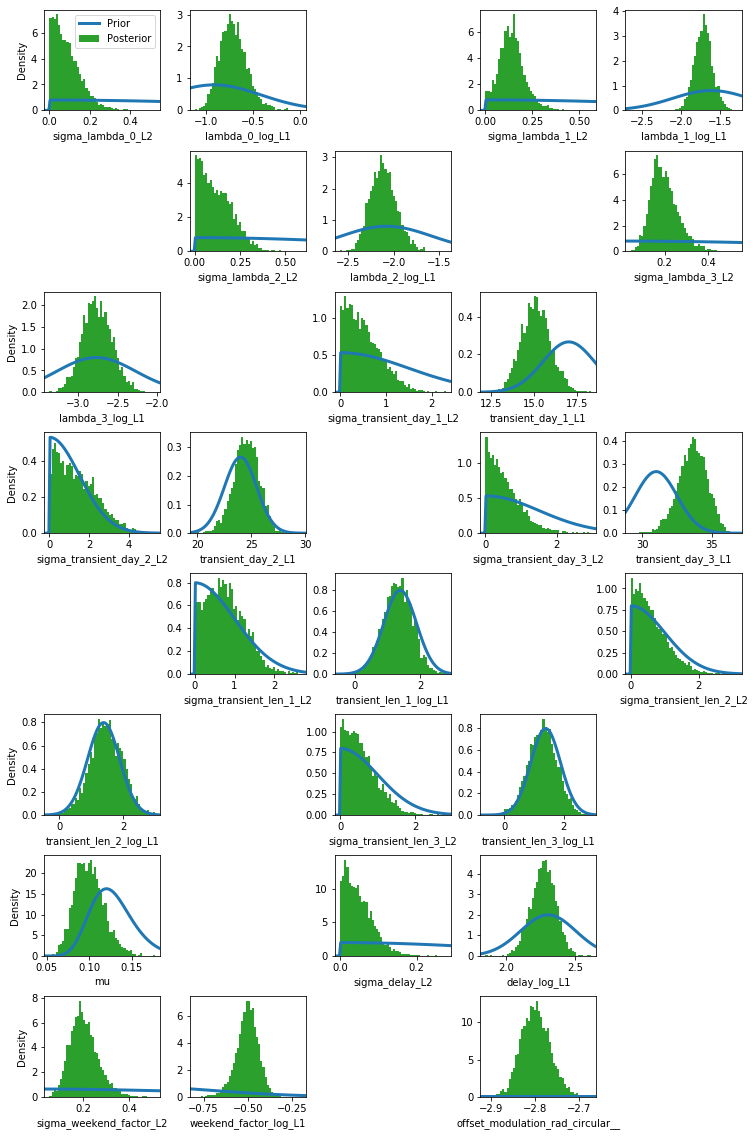

In [6]:
# varnames = cov19.plotting.get_all_free_RVs_names(model)
# num_cols = 5
# num_rows = int(np.ceil(len(varnames)/num_cols))
# x_size = num_cols * 2.5
# y_size = num_rows * 2.5

# fig, axes = plt.subplots(num_rows, num_cols, figsize = (x_size, y_size),squeeze=False)
# i_ax = 0
# for i_row, axes_row in enumerate(axes):
#     for i_col, ax in enumerate(axes_row):
#         if i_ax >= len(varnames):
#             ax.set_visible(False)
#             continue 
#         else:
#             cov19.plotting.plot_hist(model, trace, ax, varnames[i_ax], 
#                                      colors=('tab:blue', 'tab:green'))
#         if not i_col == 0:
#             ax.set_ylabel('')
#         if i_col == 0 and i_row == 0:
#             ax.legend()
#         i_ax += 1
# fig.subplots_adjust(wspace=0.25, hspace=0.4)